In [56]:
import time
import pandas as pd
import numpy as np
import pydotplus
from io import StringIO
import seaborn as sns
import matplotlib.pyplot as plt
from pprint import pprint as pp
from IPython.display import Image

from sklearn import metrics
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split
from sklearn.tree import export_graphviz
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.feature_selection import SelectFromModel
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import cross_val_score, ShuffleSplit, GridSearchCV, validation_curve, learning_curve
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score

In [17]:
np.random.seed(0)

In [18]:
df = pd.read_csv("../../Data/dataset2/train.csv")
df = df.dropna()
df = df.ffill()
df = df.bfill()
df.shape

(2000, 21)

In [4]:
price_range = df[['price_range']].to_numpy()
price_range[price_range<=1] = 0
price_range[price_range>1] = 1
y_new = pd.DataFrame(price_range, columns=['price_range'])

In [5]:
X = df.drop(columns=['price_range'])
y = y_new
y = df[['price_range']]
x_train, x_test, y_train, y_test = train_test_split(X, y, test_size=0.2)


In [57]:
clf = DecisionTreeClassifier(random_state=0)
start_time = time.time()
clf.fit(x_train, y_train)
print(f"DT Normal Model: Fit Time: {time.time() - start_time}")
start_time = time.time()
y_pred = clf.predict(x_test)
print(f"DT Normal Model: Fit Time: {time.time() - start_time}")
print(f"Number of Nodes in the tree {clf.tree_.node_count}")
print(f"accuracy_score: {accuracy_score(y_test, y_pred)}")

DT Normal Model: Fit Time: 0.01047825813293457
DT Normal Model: Fit Time: 0.001790761947631836
Number of Nodes in the tree 305
accuracy_score: 0.8325


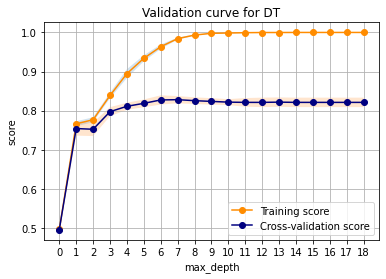

In [15]:
### Validation Curve
depth_range = np.arange(1, 20)
classifier = "DT"
param_name = "max_depth"
train_scores, test_scores = validation_curve(clf, x_train, y_train, param_name=param_name, param_range=depth_range, cv=5)
mean_train_scores = np.mean(train_scores, axis=1)
std_train_scores = np.std(train_scores, axis=1)
mean_test_scores = np.mean(test_scores, axis=1)
std_test_scores = np.std(test_scores, axis=1)
depth_range_list = np.arange(0, len(depth_range), 1)
plt.figure()
plt.xticks(np.arange(0, len(depth_range)))
plt.plot(depth_range_list, mean_train_scores, 'o-', label='Training score', color='darkorange')
plt.fill_between(depth_range_list, mean_train_scores - std_train_scores, mean_train_scores + std_train_scores, alpha=0.2)
plt.plot(depth_range_list, mean_test_scores, 'o-', label='Cross-validation score', color='navy')
plt.fill_between(depth_range_list, mean_test_scores - std_test_scores, mean_test_scores + std_test_scores, alpha=0.2)
plt.title(f'Validation curve for {classifier}')
plt.xlabel(param_name)
plt.ylabel("score")
plt.legend(loc="best")
plt.grid()
plt.savefig(os.getcwd() + '/dt_validation_curve_price.png')
plt.show()


In [51]:
fit_time_list = []
predict_time_list = []
number_nodes_list = []
for i in np.arange(1, 30):
    clf = DecisionTreeClassifier(random_state=0, max_depth=i)
    
    start_time = time.time()
    clf.fit(x_train, y_train)
    end_time = time.time() - start_time
    fit_time_list.append(end_time)
#     print(f"DT Normal Model: Fit Time: {end_time}")
    
    start_time = time.time()
    y_pred = clf.predict(x_test)
    end_time = time.time() - start_time
    predict_time_list.append(end_time)
#     print(f"DT Normal Model: Predict Time: {end_time}")
    
    number_nodes_list.append(clf.tree_.node_count)
#     print(f"Number of Nodes in the tree {clf.tree_.node_count}")
#     print("\n\n")

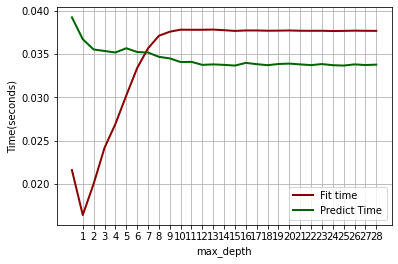

In [53]:
def normalize_data_points(points):
    return [float(i)/sum(points) for i in points]
lw = 2
plt.plot(normalize_data_points(fit_time_list), label="Fit time", color="darkred", lw=lw)
plt.plot(normalize_data_points(predict_time_list), label="Predict Time", color="darkgreen", lw=lw)
plt.xlabel(r"max_depth")
plt.ylabel("Time(seconds)")
plt.xticks(np.arange(1, len(fit_time_list), 1.0))
plt.grid()
plt.legend(loc='lower right')
plt.savefig(os.getcwd() +'/dt_fit_n_predict_time_price.png')

/nobackup/nitarora/ML/Supervised-Learning/DT


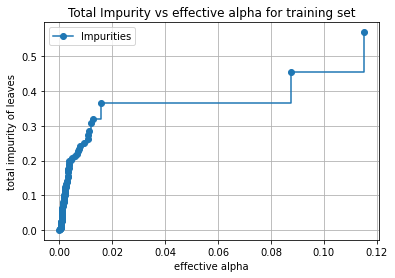

In [19]:
path = clf.cost_complexity_pruning_path(x_train, y_train)
ccp_alphas, impurities = path.ccp_alphas, path.impurities
fig, ax = plt.subplots()
plt.plot(ccp_alphas[:-1], impurities[:-1], label="Impurities",marker='o', drawstyle="steps-post")
plt.xlabel("effective alpha")
plt.ylabel("total impurity of leaves")
plt.grid()
plt.legend()
plt.savefig(os.getcwd() +'/dt_impurity_vs_alpha_price.png')
plt.title("Total Impurity vs effective alpha for training set")
print(os.getcwd())

In [26]:
# As Alpha increases - more nodes are pruned which increases the impurity of the model
# The last ccp_alphas value prunes the whole tree and leaves only 1 node
clfs = []
for ccp_alpha in ccp_alphas:
    clf = DecisionTreeClassifier(random_state=0, ccp_alpha=ccp_alpha)
    clf.fit(x_train, y_train)
    clfs.append(clf)
print("Number of nodes in the last tree is: {} with ccp_alpha: {}".format(clfs[-1].tree_.node_count, ccp_alphas[-1]))


Number of nodes in the last tree is: 1 with ccp_alpha: 0.18037387563980345


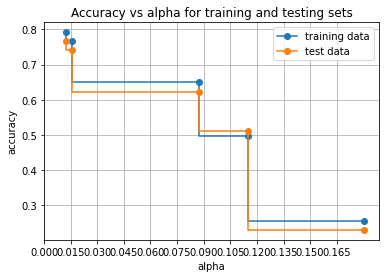

'So here we see that alpha from 0.025 to 0.005 gives us the max score for test data while keeping the impurity lower'

In [31]:
max_val = 5
train_scores = [clf.score(x_train, y_train) for clf in clfs]
test_scores = [clf.score(x_test, y_test) for clf in clfs]
fig, ax = plt.subplots()
ax.set_xlabel("alpha")
ax.set_ylabel("accuracy")
ax.set_title("Accuracy vs alpha for training and testing sets")
ax.plot(ccp_alphas[::-1][:max_val], train_scores[::-1][:max_val], marker='o', label="training data", drawstyle="steps-post")
ax.plot(ccp_alphas[::-1][:max_val], test_scores[::-1][:max_val], marker='o', label="test data", drawstyle="steps-post")
plt.xticks(np.arange(0, 0.18, 0.015))
ax.legend()
plt.grid()
plt.savefig(os.getcwd() +'/dt_accuracy_vs_alpha_price.png')
plt.show()
"""So here we see that alpha from 0.025 to 0.005 gives us the max score for test data while keeping the impurity lower"""

In [37]:
crossValScores = cross_val_score(clf, X, y, cv=5)
print("Cross Valuation Scores for unpruned tree are ", crossValScores)
print("Mean accurac# As Alpha increases - more nodes are pruned which increases the impurity of the model")
# The last ccp_alphas value prunes the whole tree and leaves only 1 node
clfs = []
for ccp_alpha in ccp_alphas:
    clf = DecisionTreeClassifier(random_state=0, ccp_alpha=ccp_alpha)
    clf.fit(x_train, y_train)
    clfs.append(clf)
print("Number of nodes in the last tree is: {} with ccp_alpha: {}".format(clfs[-1].tree_.node_count, ccp_alphas[-1]))
print("Std accuracy score is ", crossValScores.std())

Cross Valuation Scores for unpruned tree are  [0.5  0.5  0.25 0.5  0.5 ]
Mean accurac# As Alpha increases - more nodes are pruned which increases the impurity of the model
Number of nodes in the last tree is: 1 with ccp_alpha: 0.18037387563980345
Std accuracy score is  0.1


In [34]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.87      0.92      0.89        99
           1       0.79      0.74      0.76        92
           2       0.78      0.79      0.78       103
           3       0.89      0.88      0.88       106

    accuracy                           0.83       400
   macro avg       0.83      0.83      0.83       400
weighted avg       0.83      0.83      0.83       400



In [53]:
print(confusion_matrix(y_test, y_pred))

[[69 12  0  0]
 [15 76 10  0]
 [ 0 10 89 13]
 [ 0  0 17 89]]


In [38]:
pipelineA = Pipeline([('scaler', StandardScaler()), 
                      ('dt', DecisionTreeClassifier(random_state=0))])
start_time = time.time()
p = pipelineA.fit(x_train, y_train)
print(f"DT Pipeline Model: Fit Time: {time.time() - start_time}")
start_time = time.time()
y_pred_pipelineA = p.predict(x_test)
print(f"DT Pipeline Model: Predict Time: {time.time() - start_time}")

DT Pipeline Model: Fit Time: 0.012542247772216797
DT Pipeline Model: Predict Time: 0.0015501976013183594


In [39]:
ccp_alphas = [-1,-1e-3,-(1e-3)*10**-0.5, -1e-2, -(1e-2)*10**-0.5,-1e-1,-(1e-1)*10**-0.5, 0, (1e-1)*10**-0.5,1e-1,(1e-2)*10**-0.5,1e-2,(1e-3)*10**-0.5,1e-3]
param = {'dt__max_depth': np.arange(1, 20), 
         'dt__criterion': ['gini', 'entropy'], 
         'dt__ccp_alpha': ccp_alphas, 
         'dt__class_weight': ['balanced']}
clf_cv = GridSearchCV(pipelineA, n_jobs=-1, param_grid=param, refit=True, cv=5, return_train_score=True)
start_time = time.time()
clf_cv = clf_cv.fit(x_train, y_train)
print(f"DT CV Model: Fit Time: {time.time() - start_time}")
start_time = time.time()
y_pred_pipeline_cv = clf_cv.predict(x_test)
print(f"DT CV Model: Predict Time: {time.time() - start_time}")
clf_cv.best_params_


DT CV Model: Fit Time: 5.823608875274658
DT CV Model: Predict Time: 0.0026993751525878906


{'dt__ccp_alpha': 0,
 'dt__class_weight': 'balanced',
 'dt__criterion': 'entropy',
 'dt__max_depth': 10}

In [59]:
print(accuracy_score(y_test, y_pred_pipelineA))

0.835


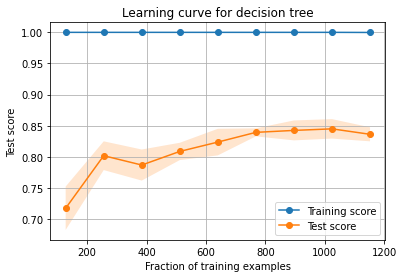

In [63]:
# Initial learning curve
# train_sizes = np.linspace(0.1, 1.0, 5)
train_sizes = np.arange(0.1, 1.0, 0.1)
clf_new = DecisionTreeClassifier(ccp_alpha=0, class_weight='balanced', criterion='entropy', max_depth=10)
train_sizes, train_scores, test_scores, fit_times, _ = learning_curve(clf_new, x_train, y_train, train_sizes=train_sizes, cv=5, return_times=True)

mean_train_scores = np.mean(train_scores, axis=1)
std_train_scores = np.std(train_scores, axis=1)
mean_test_scores = np.mean(test_scores, axis=1)
std_test_scores = np.std(test_scores, axis=1)
plt.plot(train_sizes, mean_train_scores, 'o-', label='Training score')
plt.fill_between(train_sizes, mean_train_scores - std_train_scores, mean_train_scores + std_train_scores, alpha=0.2)
plt.plot(train_sizes, mean_test_scores, 'o-', label='Test score')
plt.fill_between(train_sizes, mean_test_scores - std_test_scores, mean_test_scores + std_test_scores, alpha=0.2)
plt.title('Learning curve for decision tree')
plt.xlabel('Fraction of training examples')
plt.ylabel("Test score")
plt.legend(loc="best")
plt.grid()
plt.savefig(os.getcwd() + '/dt_learning_curve_price.png')
plt.show()

In [45]:
plt.savefig(os.getcwd() + '/dt_learning_curve_price.png')

<Figure size 432x288 with 0 Axes>

In [49]:
start_time = time.time()
print(classification_report(y_test, y_pred_pipeline_cv))
print(clf_cv.best_score_, clf_cv.best_params_)
print(f"DT CV classification_report time: {time.time() - start_time}")
# print(clf_cv.cv_results_)
sc_df = pd.DataFrame(clf_cv.cv_results_)
sc_df.dropna(inplace=True)
# sc_df.sort_values(by="rank_test_score", ascending=True)

              precision    recall  f1-score   support

           0       0.88      0.91      0.90        99
           1       0.81      0.79      0.80        92
           2       0.82      0.83      0.82       103
           3       0.90      0.89      0.90       106

    accuracy                           0.85       400
   macro avg       0.85      0.85      0.85       400
weighted avg       0.85      0.85      0.85       400

0.8474999999999999 {'dt__ccp_alpha': 0, 'dt__class_weight': 'balanced', 'dt__criterion': 'entropy', 'dt__max_depth': 10}
DT CV classification_report time: 0.0038309097290039062


{'dt__ccp_alpha': 0,
 'dt__class_weight': 'balanced',
 'dt__criterion': 'entropy',
 'dt__max_depth': 10}

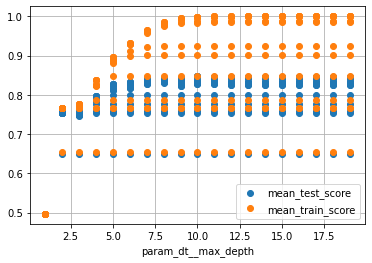

In [50]:
# from sklearn import tree
# print(tree.export_text(clf))
# sc_df.columns
# sc_df = sc_df.drop_duplicates(subset=['mean_test_score', 'mean_train_score', 'param_dt__max_depth'], keep="last")
# sc_df.drop(sc_df[sc_df['param_dt__criterion'] == 'gini'].index, inplace = True) 
sc_df.plot(x='param_dt__max_depth', y=['mean_test_score', 'mean_train_score'], style='o', grid=True)
clf_cv.best_params_

In [61]:
def plot_grid_search_validation_curve(grid, param_to_vary, title='Validation Curve', ylim=None, xlim=None, log=None):
    """Plots train and cross-validation scores from a GridSearchCV instance's
    best params while varying one of those params."""

    df_cv_results = pd.DataFrame(grid.cv_results_)
    train_scores_mean = df_cv_results['mean_train_score']
    valid_scores_mean = df_cv_results['mean_test_score']
    train_scores_std = df_cv_results['std_train_score']
    valid_scores_std = df_cv_results['std_test_score']

    param_cols = [c for c in df_cv_results.columns if c[:6] == 'param_']
    param_ranges = [grid.param_grid[p[6:]] for p in param_cols]
    param_ranges_lengths = [len(pr) for pr in param_ranges]

    train_scores_mean = np.array(train_scores_mean).reshape(*param_ranges_lengths)
    valid_scores_mean = np.array(valid_scores_mean).reshape(*param_ranges_lengths)
    train_scores_std = np.array(train_scores_std).reshape(*param_ranges_lengths)
    valid_scores_std = np.array(valid_scores_std).reshape(*param_ranges_lengths)

    param_to_vary_idx = param_cols.index('param_{}'.format(param_to_vary))

    slices = []
    for idx, param in enumerate(grid.best_params_):
        if (idx == param_to_vary_idx):
            slices.append(slice(None))
            continue
        best_param_val = grid.best_params_[param]
        idx_of_best_param = 0
        if isinstance(param_ranges[idx], np.ndarray):
            idx_of_best_param = param_ranges[idx].tolist().index(best_param_val)
        else:
            idx_of_best_param = param_ranges[idx].index(best_param_val)
        slices.append(idx_of_best_param)

    train_scores_mean = train_scores_mean[tuple(slices)]
    valid_scores_mean = valid_scores_mean[tuple(slices)]
    train_scores_std = train_scores_std[tuple(slices)]
    valid_scores_std = valid_scores_std[tuple(slices)]

    plt.clf()

    plt.title(title)
    plt.xlabel(param_to_vary)
    plt.ylabel('Score')

    if (ylim is None):
        plt.ylim(0.0, 1.1)
    else:
        plt.ylim(*ylim)

    if (not (xlim is None)):
        plt.xlim(*xlim)

    lw = 2

    plot_fn = plt.plot
    if log:
        plot_fn = plt.semilogx

    param_range = param_ranges[param_to_vary_idx]
#     if (not isinstance(param_range[0], numbers.Number)):
#         param_range = [str(x) for x in param_range]
    plot_fn(param_range, train_scores_mean, label='Training score', color='r', lw=lw)
    plt.fill_between(param_range, train_scores_mean - train_scores_std, train_scores_mean + train_scores_std, alpha=0.1, color='r', lw=lw)
    plot_fn(param_range, valid_scores_mean, label='Cross-validation score', color='b', lw=lw)
    plt.fill_between(param_range, valid_scores_mean - valid_scores_std, valid_scores_mean + valid_scores_std, alpha=0.1, color='b', lw=lw)

    plt.legend(loc='lower right')
    plt.grid()
    plt.show()


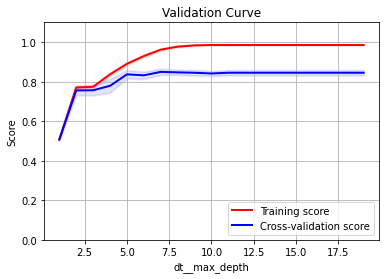

None
{'dt__ccp_alpha': 0.0031622776601683794, 'dt__class_weight': 'balanced', 'dt__criterion': 'entropy', 'dt__max_depth': 7}


In [62]:
print(plot_grid_search_validation_curve(clf_cv, 'dt__max_depth', log=False))
print(clf_cv.best_params_)

In [64]:
import numpy as np
from sklearn.model_selection import learning_curve


def plot_learning_curve(estimator, title, X, y, axes=None, ylim=None, cv=None, n_jobs=None, train_sizes=np.linspace(.1, 1.0, 5)):
    if axes is None:
        _, axes = plt.subplots(1, 3, figsize=(20, 5))

    axes[0].set_title(title)
    if ylim is not None:
        axes[0].set_ylim(*ylim)
    axes[0].set_xlabel("Training examples")
    axes[0].set_ylabel("Score")

    train_sizes, train_scores, test_scores, fit_times, _ = learning_curve(estimator, X, y, cv=cv, n_jobs=n_jobs, train_sizes=train_sizes, return_times=True)
    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)
    fit_times_mean = np.mean(fit_times, axis=1)
    fit_times_std = np.std(fit_times, axis=1)

    # Plot learning curve
    axes[0].grid()
    axes[0].fill_between(train_sizes, train_scores_mean - train_scores_std, train_scores_mean + train_scores_std, alpha=0.1, color="r")
    axes[0].fill_between(train_sizes, test_scores_mean - test_scores_std, test_scores_mean + test_scores_std, alpha=0.1, color="g")
    axes[0].plot(train_sizes, train_scores_mean, 'o-', color="r", label="Training score")
    axes[0].plot(train_sizes, test_scores_mean, 'o-', color="g", label="Cross-validation score")
    axes[0].legend(loc="best")

    # Plot n_samples vs fit_times
    axes[1].grid()
    axes[1].plot(train_sizes, fit_times_mean, 'o-')
    axes[1].fill_between(train_sizes, fit_times_mean - fit_times_std, fit_times_mean + fit_times_std, alpha=0.1)
    axes[1].set_xlabel("Training examples")
    axes[1].set_ylabel("fit_times")
    axes[1].set_title("Scalability of the model")

    # Plot fit_time vs score
    axes[2].grid()
    axes[2].plot(fit_times_mean, test_scores_mean, 'o-')
    axes[2].fill_between(fit_times_mean, test_scores_mean - test_scores_std, test_scores_mean + test_scores_std, alpha=0.1)
    axes[2].set_xlabel("fit_times")
    axes[2].set_ylabel("Score")
    axes[2].set_title("Performance of the model")

    return plt


title = "Learning Curves (Decision Tree)"
# cv = ShuffleSplit(n_splits=10, random_state=0, test_size=0.2, train_size=None)
# plot_learning_curve(clf_cv.estimator, title, X, y,  ylim=(0.5, 1.01), cv=cv, n_jobs=-1)

'So here, we see that by increasing the max_depth param, the training_score becomes better. Variance increases with increase in training size and max_depth\nBut with low max_depth value, we see that the training score goes down with increase in size as we are now underfitting the data and pruning too much.'

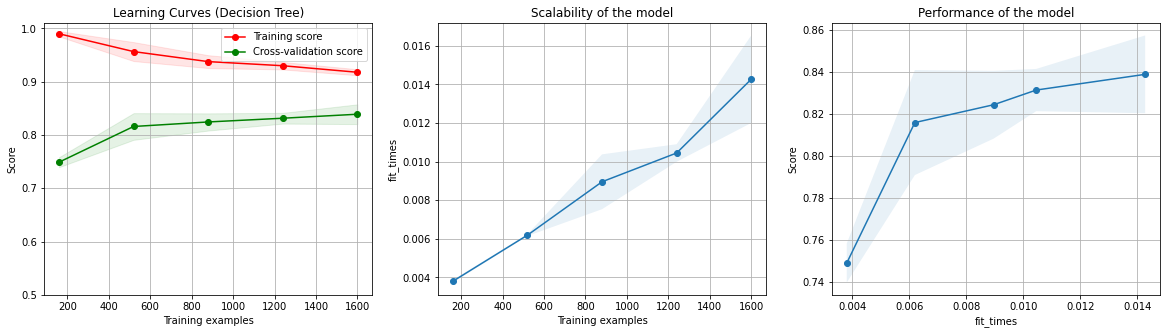

In [66]:
dt_classifier = DecisionTreeClassifier(criterion="entropy", max_depth=6, class_weight="balanced")
plot_learning_curve(dt_classifier, title, X, y, ylim=(0.5, 1.01), cv=5, n_jobs=-1)

"""So here, we see that by increasing the max_depth param, the training_score becomes better. Variance increases with increase in training size and max_depth
But with low max_depth value, we see that the training score goes down with increase in size as we are now underfitting the data and pruning too much."""

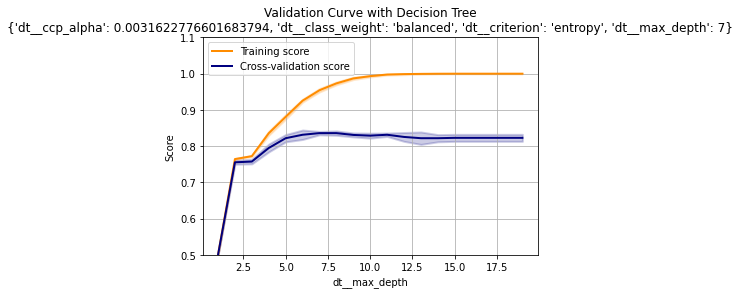

'In this case, we see the increase in max_depth yields the same result after some time. Either we created all the nodes and reached max node size'

In [67]:
from sklearn.model_selection import validation_curve

param_range = np.arange(1, 20, 1)
train_scores, test_scores = validation_curve(clf_cv.estimator, X, y, param_name="dt__max_depth", param_range=param_range,scoring="accuracy", n_jobs=1)
train_scores_mean = np.mean(train_scores, axis=1)
train_scores_std = np.std(train_scores, axis=1)
test_scores_mean = np.mean(test_scores, axis=1)
test_scores_std = np.std(test_scores, axis=1)

plt.title(f"Validation Curve with Decision Tree\n{clf_cv.best_params_}")
plt.xlabel(r"dt__max_depth")
plt.ylabel("Score")
plt.ylim(0.5, 1.1)
lw = 2
plt.plot(param_range, train_scores_mean, label="Training score", color="darkorange", lw=lw)
plt.fill_between(param_range, train_scores_mean - train_scores_std, train_scores_mean + train_scores_std, alpha=0.2, color="darkorange", lw=lw)
plt.plot(param_range, test_scores_mean, label="Cross-validation score", color="navy", lw=lw)
plt.fill_between(param_range, test_scores_mean - test_scores_std, test_scores_mean + test_scores_std, alpha=0.2, color="navy", lw=lw)
plt.legend(loc="best")
plt.grid()
plt.show()
"""In this case, we see the increase in max_depth yields the same result after some time. Either we created all the nodes and reached max node size"""

In [240]:
clf_cv.estimator.get_params()

{'memory': None,
 'steps': [('scaler', StandardScaler()), ('dt', DecisionTreeClassifier())],
 'verbose': False,
 'scaler': StandardScaler(),
 'dt': DecisionTreeClassifier(),
 'scaler__copy': True,
 'scaler__with_mean': True,
 'scaler__with_std': True,
 'dt__ccp_alpha': 0.0,
 'dt__class_weight': None,
 'dt__criterion': 'gini',
 'dt__max_depth': None,
 'dt__max_features': None,
 'dt__max_leaf_nodes': None,
 'dt__min_impurity_decrease': 0.0,
 'dt__min_impurity_split': None,
 'dt__min_samples_leaf': 1,
 'dt__min_samples_split': 2,
 'dt__min_weight_fraction_leaf': 0.0,
 'dt__presort': 'deprecated',
 'dt__random_state': None,
 'dt__splitter': 'best'}

In [71]:
import time
import copy

# Lets make a time chart for different test train fractions
def timing_curve(clf, X, Y, train_sizes=np.arange(0.1, 1., 0.1)):
    out = {
        'train_size': [],
        'fit_time': [],
        'pred_time':  [],
    }
    
    for frac in train_sizes:
        clf_clone = copy.copy(clf)
        
        x_train,x_test, y_train, y_test = train_test_split(X, Y, test_size=frac, random_state=1)
        out['train_size'].append(x_train.shape[0])
        
        st = time.time()
        np.random.seed(55)
        clf_clone.fit(x_train, y_train)
        out['fit_time'].append(time.time() - st)
        
        st = time.time()
        clf_clone.predict(x_test)
        out['pred_time'].append(time.time() - st)
    
    out_df = pd.DataFrame(out)
    out_df['fit_time_per_samp'] = out_df['fit_time'] / out_df['train_size']
    out_df['pred_time_per_samp'] = out_df['pred_time'] / out_df['train_size']
    out_df = out_df.set_index('train_size')
    
    return out_df

def save_timing_curve(timing_df, dataset, estimator_type, results_dir='./results/', extras=''):
    """Saves a GridSearchCV or RandomizedSearchCV result to a file"""
    tz = timezone('US/Eastern')
    date = datetime.now(tz).isoformat(timespec='minutes', sep='_').replace(':', '-')
    filename = 'timing_%s_%s_%s_%s' % (dataset, estimator_type, date, extras)
    path = Path(results_dir + filename + '.pkl')
    joblib.dump(timing_df, path)

<AxesSubplot:xlabel='train_size'>

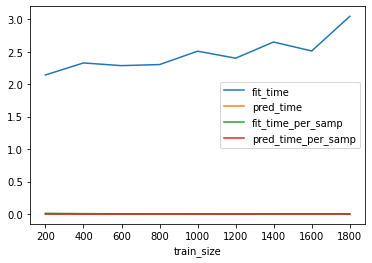

In [73]:
import copy
clone = copy.copy(clf_cv)
tc_df = timing_curve(clone, X, y)
tc_df.plot()

In [ ]:
(tc_df / tc_df.iloc[0])[['fit_time', 'fit_time_per_samp']].plot()
(tc_df / tc_df.iloc[0])

<AxesSubplot:xlabel='train_size'>

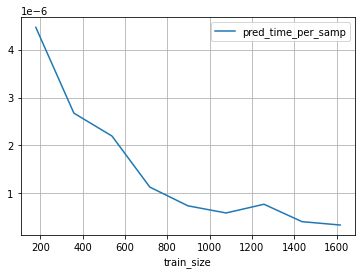

In [166]:
tc_df[['pred_time_per_samp']].plot(grid=True)

In [19]:
# feature_columns = (df.columns.tolist())
# feature_columns.remove('price_range')
# dot_data = StringIO()

# out_file = export_graphviz(clf, out_file=dot_data, filled=True, rounded=True, special_characters=True, feature_names=feature_columns, class_names=['Very Low', 'Low', 'High','Very High'])
# graph = pydotplus.graph_from_dot_data(dot_data.getvalue())
# graph.write_png('output.png')

# Image(graph.create_png())

In [ ]:
# DT Pruning Mechanism

In [18]:
# fig = plt.figure(figsize=(25, 20))
# _ = tree.plot_tree(clf, feature_names=df.columns.tolist().remove('price_range'), class_names=['0','1', '2', '3'], filled=True)
# fig.savefig('dt_plot_1.png', dpi=1200)
# from dtreeviz.trees import dtreeviz
# viz = dtreeviz(clf, X, y['price_range'],
#                 target_name="price_range",
#                 feature_names=df.columns.tolist(),
#                 class_names=['very_low','low', 'high', 'very_high'])
# viz.view()
